# BAIT - Baseline Assessment of 
Analysing how teams attempt to disguise and mislead defenses, based on their set-up.

Note, you must run the `run_pass_prediction_model.ipynb` notebook first to obtain the `test_set_play_type_predicitons.csv` file, which this notebook uses.

In [7]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
import os

# Collect NFL logos for use in plotting
Due to a version issue with the `nfl_data_py` package, I have manually uploaded the CSV containing the link to team logos for each NFL team. 

[Code is borrowed from this repository to download logos for use in plotting.](https://github.com/tbryan2/NFL-Python-Team-Logo-Viz)

In [68]:
logos = pd.read_csv("../../images/nfl_team_logos.csv")

# Initialize an empty list for the logo file paths
logo_paths = []

# Initialize an empty list for the team abbreviations
team_abbr = []

# Create a folder for the image files if it doesn't exist

if not os.path.exists("../../images/logos"):
    os.makedirs("../../images/logos")

# Pull the team logos from the URL and save them in the logos folder, save the file paths to
for team in range(len(logos)):
    urllib.request.urlretrieve(logos['team_logo_espn'][team], f"../../images/logos/{logos['team_abbr'][team]}.png")
    logo_paths.append(f"../../images/logos/{logos['team_abbr'][team]}.png")
    team_abbr.append(logos['team_abbr'][team])

# Add the file paths to the logos dataframe
logos["logo_file_path"] = "../../images/logos/" + logos["team_abbr"] + ".png"

In [69]:
logos.head()

,Unnamed: 0,team_abbr,team_name,team_id,team_nick,team_conf,team_division,team_color,team_color2,team_color3,team_color4,team_logo_wikipedia,team_logo_espn,team_wordmark,team_conference_logo,team_league_logo,team_logo_squared,logo_file_path
0,0,ARI,Arizona Cardinals,3800,Cardinals,NFC,NFC West,#97233F,#000000,#ffb612,#a5acaf,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/ari.png,https://github.com/nflverse/nflverse-pbp/raw/m...,https://github.com/nflverse/nflverse-pbp/raw/m...,https://raw.githubusercontent.com/nflverse/nfl...,https://github.com/nflverse/nflverse-pbp/raw/m...,../../images/logos/ARI.png
1,1,ATL,Atlanta Falcons,200,Falcons,NFC,NFC South,#A71930,#000000,#a5acaf,#a30d2d,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/atl.png,https://github.com/nflverse/nflverse-pbp/raw/m...,https://github.com/nflverse/nflverse-pbp/raw/m...,https://raw.githubusercontent.com/nflverse/nfl...,https://github.com/nflverse/nflverse-pbp/raw/m...,../../images/logos/ATL.png
2,2,BAL,Baltimore Ravens,325,Ravens,AFC,AFC North,#241773,#9E7C0C,#9e7c0c,#c60c30,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/bal.png,https://github.com/nflverse/nflverse-pbp/raw/m...,https://github.com/nflverse/nflverse-pbp/raw/m...,https://raw.githubusercontent.com/nflverse/nfl...,https://github.com/nflverse/nflverse-pbp/raw/m...,../../images/logos/BAL.png
3,3,BUF,Buffalo Bills,610,Bills,AFC,AFC East,#00338D,#C60C30,#0c2e82,#d50a0a,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/buf.png,https://github.com/nflverse/nflverse-pbp/raw/m...,https://github.com/nflverse/nflverse-pbp/raw/m...,https://raw.githubusercontent.com/nflverse/nfl...,https://github.com/nflverse/nflverse-pbp/raw/m...,../../images/logos/BUF.png
4,4,CAR,Carolina Panthers,750,Panthers,NFC,NFC South,#0085CA,#000000,#bfc0bf,#0085ca,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500-dark...,https://github.com/nflverse/nflverse-pbp/raw/m...,https://github.com/nflverse/nflverse-pbp/raw/m...,https://raw.githubusercontent.com/nflverse/nfl...,https://github.com/nflverse/nflverse-pbp/raw/m...,../../images/logos/CAR.png


# Create indicators

In [70]:
play_type_predictions = pd.read_csv('test_set_play_type_predictions.csv')
play_type_predictions.head()

,gameId,playId,quarter,down,logYardsToGo,distanceToEndzone,scoreDifference,gameSecondsRemaining,offense_x_centroid,offense_x_rel_centroid,...,playHadMotionAndCameSet,playHadPlayersInMotionAtSnap,playHadPreSnapMotion,game_state_only_prob,spatial_line_set_prob,spatial_ball_snap_prob,combined_line_set_prob,combined_ball_snap_prob,change_in_spatial_prob,change_in_combined_prob
0,2022102302,2655,3,1,2.302585,79,18,1014,29.221818,-1.358182,...,False,False,False,0.421760,0.875775,0.966138,0.868489,0.954371,0.090363,0.085882
1,2022103004,3146,4,3,2.484907,80,-14,120,28.024545,-1.785454,...,True,False,True,0.972673,0.727244,0.941106,0.662838,0.982003,0.213862,0.319165
2,2022110610,348,1,2,2.302585,23,0,3268,84.985455,-1.784546,...,False,False,False,0.617190,0.941180,0.898290,0.935905,0.907400,-0.042889,-0.028505
3,2022102700,2799,3,2,2.079442,27,0,1036,80.576364,-2.243636,...,False,True,True,0.700879,0.250731,0.231155,0.373693,0.310816,-0.019575,-0.062877
4,2022110605,3861,4,1,2.302585,60,-23,29,47.868182,-1.611818,...,False,False,False,0.934691,0.860648,0.742743,0.939516,0.838128,-0.117905,-0.101389


In [71]:
# Add useful indicators
play_type_predictions["over_5_percent_change"] = np.where(abs(play_type_predictions["change_in_combined_prob"]) > 0.05, 1, 0)
play_type_predictions["over_10_percent_change"] = np.where(abs(play_type_predictions["change_in_combined_prob"]) > 0.1, 1, 0)
play_type_predictions["over_20_percent_change"] = np.where(abs(play_type_predictions["change_in_combined_prob"]) > 0.2, 1, 0)

play_type_predictions["pass_prob_increased_by_10_percent"] = np.where(play_type_predictions["change_in_combined_prob"] > 0.1, 1, 0)
play_type_predictions["run_prob_increased_by_10_percent"] = np.where(play_type_predictions["change_in_combined_prob"] < -0.1, 1, 0)
play_type_predictions["significant_prob_change"] = np.where(abs(play_type_predictions["change_in_combined_prob"]) > 0.1, 1, 0)

play_type_predictions["play_probability_change_category"] = np.where(play_type_predictions["change_in_combined_prob"] > 0.1, "pass_prob_increased_by_10_percent", np.where(play_type_predictions["change_in_combined_prob"] < -0.1, "run_prob_increased_by_10_percent", "no_significant_change"))

play_type_predictions["is_bait_play"] = np.where((play_type_predictions["play_probability_change_category"] == "pass_prob_increased_by_10_percent") & (play_type_predictions["playType"] == "run"), 
                                                   1,
                                                   np.where((play_type_predictions["play_probability_change_category"] == "run_prob_increased_by_10_percent") & (play_type_predictions["playType"] == "pass"), 1, 0))


In [72]:
# Average probability at line_snap vs average probability at ball_snap
team_average_probability = play_type_predictions.\
    groupby(["possessionTeam"]).\
    agg(count=("is_bait_play", "count"),
        average_line_set_pass_prob=("combined_line_set_prob", "mean"),
        average_ball_snap_pass_prob=("combined_ball_snap_prob", "mean"),
        average_increase_in_pass_prob=("change_in_combined_prob", "mean"),
        actual_pass_rate=("isPass", "mean")).\
    reset_index(drop=False).\
    merge(logos, left_on="possessionTeam", right_on="team_abbr", how="left")

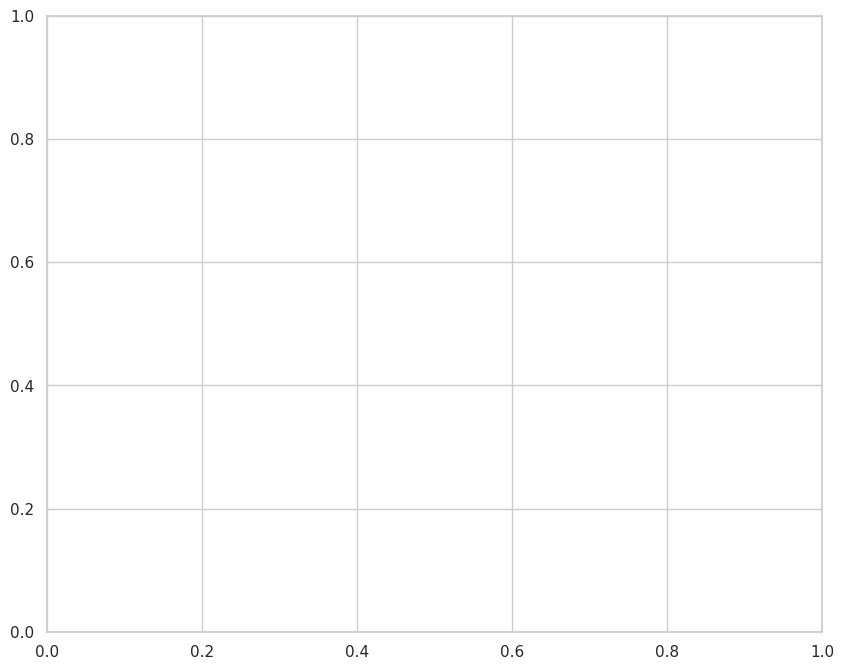

In [77]:
# Create function to do plotting with logos
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(10, 8))
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

# def add_image(image_path, x0, y0, target_size=(30, 30)):  # specify target size in pixels
#     # Open and resize image with PIL
#     img = Image.open(image_path)
#     # Use high-quality downsampling
#     img = img.resize(target_size, Image.Resampling.LANCZOS)
#     # Convert to numpy array
#     img_array = np.array(img)
    
#     # Use OffsetImage without zoom (or zoom=1)
#     im = OffsetImage(img_array)
#     ab = AnnotationBbox(im, (x0, y0), frameon=False)
#     ax.add_artist(ab)

def add_image(image_path, x0, y0, fixed_size=(40, 40)):  # specify desired size in pixels
    # Load and resize image
    img = Image.open(image_path)
    img = img.resize(fixed_size, Image.Resampling.LANCZOS)  # LANCZOS provides good quality
    img_array = np.array(img)
    
    # Create annotation without zoom parameter
    im = OffsetImage(img_array)
    ab = AnnotationBbox(im, (x0, y0), frameon=False)
    ax.add_artist(ab)

In [80]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=2000)
sns.scatterplot(data=team_average_probability, x="average_increase_in_pass_prob", y="actual_pass_rate", alpha=0)

# Add images at each data point
for x_coord, y_coord, image_path in zip(team_average_probability["average_increase_in_pass_prob"], team_average_probability["actual_pass_rate"], team_average_probability["logo_file_path"]):
    add_image(image_path, x_coord, y_coord)

plt.xlabel('Average pre-snap increase in pass probability')
plt.ylabel('Pass rate')
plt.title('Which teams change their pre-snap pass probability the most?')

plt.show()

In [81]:
play_type_predictions.groupby("is_bait_play").\
    agg(count=("is_bait_play", "count"),
        avg_epa=("expectedPointsAdded", "mean"),
        median_epa=("expectedPointsAdded", "median"))

,count,avg_epa,median_epa
is_bait_play,,,
0,4434,-0.027817,-0.181301
1,458,0.041693,-0.158375


In [82]:
play_type_predictions.groupby("significant_prob_change").\
    agg(count=("significant_prob_change", "count"),
        avg_epa=("expectedPointsAdded", "mean"),
        median_epa=("expectedPointsAdded", "median"))

,count,avg_epa,median_epa
significant_prob_change,,,
0,3472,-0.034558,-0.171993
1,1420,0.011085,-0.185755


In [83]:
play_type_predictions.groupby(["significant_prob_change", "is_bait_play"]).\
    agg(count=("significant_prob_change", "count"),
        avg_epa=("expectedPointsAdded", "mean"),
        median_epa=("expectedPointsAdded", "median"))

count   avg_epa  median_epa
significant_prob_change is_bait_play                             
0                       0              3472 -0.034558   -0.171993
1                       0               962 -0.003487   -0.203207
                        1               458  0.041693   -0.158375